<a href="https://colab.research.google.com/github/GLOMQuyet/Denoising-Diffusion-Models-in-Keras/blob/main/DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import math
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, channels,**kwargs):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads = 4,key_dim=self.channels)
        self.ln = tf.keras.layers.LayerNormalization()
        self.ff_self = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dense(channels),
            tfa.layers.GELU(),
            tf.keras.layers.Dense(channels)
        ]
        )
    def build(self,x):
        self.reshape1 = tf.keras.layers.Reshape((x[1]*x[2],self.channels))
        self.reshape2 = tf.keras.layers.Reshape((x[1],x[2],self.channels))
    def call(self, x):

        x = self.reshape1(x)
        x_ln = self.ln(x)

        attention_value = self.mha(x_ln, x_ln, x_ln)
        
        attention_value = attention_value + x
        
        attention_value = self.ff_self(attention_value) + attention_value
        
        return self.reshape2(attention_value)


In [ ]:
class DoubleConv(tf.keras.layers.Layer):
    def __init__(self, out_channels, mid_channels=None, residual=False):
        super(DoubleConv,self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(mid_channels, kernel_size=3, padding='same', use_bias=False),
            tfa.layers.GroupNormalization(1),
            tfa.layers.GELU(),
            tf.keras.layers.Conv2D(out_channels, kernel_size=3, padding='same', use_bias=False),
            tfa.layers.GroupNormalization(1)
        ]
        
        )
        self.gelu = tfa.layers.GELU()

    def call(self, x):
        if self.residual:
            return self.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


In [ ]:
class SILU(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(SILU,self).__init__()
        self.sigmoid = tf.keras.layers.Activation("sigmoid")
    def call(self,x):
        theta = 1.0
        return x* self.sigmoid(theta*x)

In [ ]:

class Down(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super(Down,self).__init__()

        self.maxpool_conv = tf.keras.Sequential(
            [
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            DoubleConv(in_channels,residual=True),
            DoubleConv(out_channels)
        ]
        )

        self.emb_layer = tf.keras.Sequential([
            SILU(),
            tf.keras.layers.Dense(out_channels)]
        )

    def repeat(self,t,x):
        t = t[:,None,None,:]

        t = tf.repeat(t,[x.shape[1]],axis=1)
        t = tf.repeat(t,[x.shape[2]],axis=2)
        return t
    def call(self, x, t):
        
        x = self.maxpool_conv(x)
        t = self.emb_layer(t)
        emb =  self.repeat(t,x)

        return x + emb

In [ ]:
class Up(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super(Up,self).__init__()

        self.up = tf.keras.layers.UpSampling2D(size=2,interpolation="bilinear")
        self.conv = tf.keras.Sequential(
            [
            DoubleConv(in_channels,residual=True),
            DoubleConv(out_channels,in_channels//2)
        ]
        )

        self.emb_layer = tf.keras.Sequential([
            SILU(),
            tf.keras.layers.Dense(out_channels)  
        ]
        )
        self.concat = tf.keras.layers.Concatenate(axis=-1)

    def repeat(self,t,x):
        t = t[:,None,None,:]

        t = tf.repeat(t,[x.shape[1]],axis=1)
        t = tf.repeat(t,[x.shape[2]],axis=2)
        return t

    def call(self, x, skip_x,t):
        x = self.up(x)
        x = self.concat([skip_x,x])
        x = self.conv(x)      
        t = self.emb_layer(t)
        emb =  self.repeat(t,x)
        return x + emb

In [ ]:
class Encoding(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Encoding,self).__init__()
        
    def call(self,t,channels):
        inv_freq = 1.0 / (10000 ** (np.arange(start=0, stop = channels, step=2)/ channels))
        t = tf.cast(t[...,tf.newaxis],dtype=tf.double)

        pos_enc_a = tf.math.sin(inv_freq * tf.repeat(t,repeats=[channels//2],axis=-1))
        pos_enc_b = tf.math.cos(inv_freq * tf.repeat(t,repeats=[channels//2],axis=-1))

        pos_enc = tf.concat([pos_enc_a, pos_enc_b], axis=-1)
        return pos_enc

In [ ]:
class UNet(tf.keras.Model):
    def __init__(self, c_in=1, c_out=1, time_dim=256,**kwargs):
        super(UNet,self).__init__()

        self.time_dim = time_dim
        self.inc = DoubleConv(64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)

        self.bot1 = DoubleConv(512)
        self.bot2 = tf.keras.layers.MultiHeadAttention(num_heads = 4,key_dim=512)
        self.bot3 = DoubleConv(256)

        self.up1 = Up(512, 128)
        self.sa3 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa4 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.outc = tf.keras.layers.Conv2D(c_out, kernel_size=1)
        self.pos_encoding = Encoding()

    def call(self, x, t):
        t = self.pos_encoding(t, self.time_dim)
        x1 = self.inc(x)
        
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4,x4,x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa3(x)     
        x = self.up2(x, x2, t)
        x = self.sa4(x)
        x = self.up3(x, x1, t)
        output = self.outc(x)
        return output

In [ ]:
if __name__ == '__main__':
    net = UNet()
    x = np.random.randn(1,32,32,1)
    t = tf.constant([500] * x.shape[0])
    print(net(x, t).shape)
    net.summary()

(1, 32, 32, 1)
Model: "u_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 double_conv_30 (DoubleConv)  multiple                 37696     
                                                                 
 down_6 (Down)               multiple                  328576    
                                                                 
 self_attention_8 (SelfAtten  multiple                 297344    
 tion)                                                           
                                                                 
 down_7 (Down)               multiple                  1246976   
                                                                 
 self_attention_9 (SelfAtten  multiple                 1184512   
 tion)                                                           
                                                                 
 down_8 (Down)               multiple       

In [ ]:
# HYPARAMETER

# data
num_epochs = 20  # train for at least 50 epochs for good results
image_size = 32

# optimization
batch_size = 256
learning_rate = 1e-3
weight_decay = 1e-4

# model
timesteps = 500
a_min = 0.0001
a_max = 0.02

# create a fixed beta schedule
beta = np.linspace(a_min,a_max, timesteps+1)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,img_paths,image_size,batch_size,dim=(28,28),n_channels=1,shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.image_size = [image_size,image_size]
        self.img_paths = img_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.img_indexes = np.arange(len(self.img_paths))
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X = self.__data_generation(list_IDs_temps)
        return X
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.img_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, list_IDs_temps):
        X = np.empty((self.batch_size, *self.dim))

        for i, ID in enumerate(list_IDs_temps):
            X[i,] = self.img_paths[ID]
        X = X[:,:,:, np.newaxis]
        X = tf.image.resize(X,size = self.image_size)
        X = tf.cast(X/255.0,dtype=tf.float32)
        return X

In [ ]:
class Forward_Noise(tf.keras.layers.Layer):

  def __init__(self,sqrt_alpha_bar,one_minus_sqrt_alpha_bar,**kwargs):
    super(Forward_Noise,self).__init__(**kwargs)
    self.sqrt_alpha_bar = sqrt_alpha_bar
    self.one_minus_sqrt_alpha_bar = one_minus_sqrt_alpha_bar

  def forward_noise(self,x_0,t):
    noise = tf.random.normal(x_0.shape)
    reshaped_sqrt_alpha_bar_t = tf.cast(tf.experimental.numpy.reshape(tf.experimental.numpy.take(self.sqrt_alpha_bar, t), (-1, 1, 1, 1)),tf.float32)
    reshaped_one_minus_sqrt_alpha_bar_t = tf.cast(tf.experimental.numpy.reshape(tf.experimental.numpy.take(self.one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1)),tf.float32)
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image,noise

  def call(self,x_0,t):
    noise_img,noise = self.forward_noise(x_0,t)
    return noise_img,noise


In [ ]:
class Generator(tf.keras.layers.Layer):
  def __init__(self,timesteps,**kwargs):
    super(Generator,self).__init__()
    self.timesteps = timesteps
    
  def generate_timestamp(self,num):
    return tf.random.uniform(shape=[num], minval=0, maxval=self.timesteps, dtype=tf.int32)
  def call(self,x):
    x = self.generate_timestamp(x)
    return x

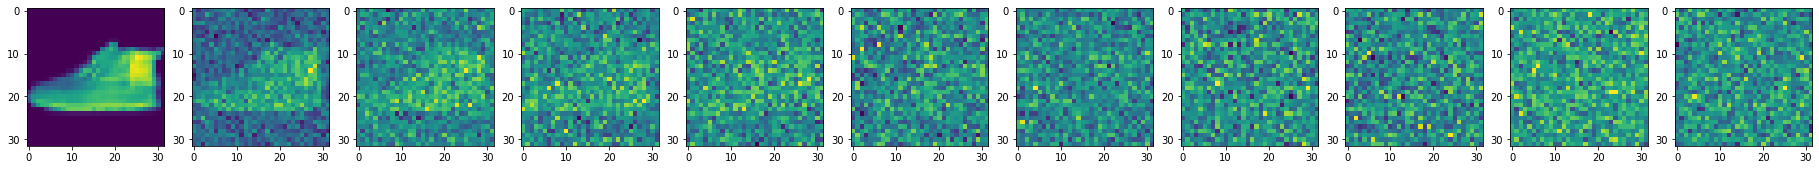

In [ ]:
forward_noise = Forward_Noise(sqrt_alpha_bar,one_minus_sqrt_alpha_bar)
generate_timestamp = Generator(timesteps)
train_generator = DataGenerator(x_train, image_size = image_size,batch_size =batch_size,shuffle=True)
val_generator = DataGenerator(x_test,image_size = image_size,batch_size=batch_size,shuffle=True)
# Let us visualize the output image at a few timestamps
sample_mnist = train_generator.__getitem__(1)[0]
fig = plt.figure(figsize=(32,50))

for index, i in enumerate([0,50,100,150,200,250,300,350,400,450,500]):
    noisy_im, noise = forward_noise(sample_mnist, np.array([i,]))
    plt.subplot(1, 11, index+1)
    plt.imshow(np.squeeze(noisy_im))
plt.show()


In [ ]:
# create our checkopint manager
ckpt = tf.train.Checkpoint(net=net)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=2)

# load from a previous checkpoint if it exists, else initialize the model from scratch

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

loss_fn = tf.keras.losses.MeanSquaredError()
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.MeanSquaredError('mse train')
val_acc_metric = tf.keras.metrics.MeanSquaredError('mse val')
# Optimizers
opt = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay)

Restored from ./checkpoints/ckpt-4


In [ ]:
@tf.function
def train_step(batch):   
    timestep_values = generate_timestamp(batch.shape[0])
    noised_image, noise = forward_noise(batch, timestep_values)
    with tf.GradientTape() as tape:
        prediction = net(noised_image, timestep_values)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, net.trainable_variables)
    opt.apply_gradients(zip(gradients, net.trainable_variables))
    train_acc_metric.update_state(noise,prediction)
    return loss_value

@tf.function
def test_step(batch):
    timestep_values = generate_timestamp(batch.shape[0])

    noised_image, noise = forward_noise(batch, timestep_values)
    
    prediction = net(noised_image, timestep_values)
    loss_value = loss_fn(noise, prediction)
    # Update training metric.
    val_acc_metric.update_state(noise,prediction)
    return loss_value

In [ ]:
from tqdm.notebook import trange
import time
for e in trange(num_epochs): 
    print("\nStart of epoch %d" % (e,))
    start_time = time.time()
    
    # this is cool utility in Tensorflow that will create a nice looking progress bar
    for i, batch in enumerate(iter(train_generator)):
        # run the training loop
        loss = train_step(batch)

     # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()

    print("Training MSE: %.4f" % (float(train_acc),))
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    
    for i, batch in enumerate(iter(val_generator)):
        # run the training loop
        val_loss = test_step(batch)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
        
    print("Validation MSE: %.4f" % (float(val_acc),))
    # print("validation KID: %.4f" % (float(val_kid),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    
    ckpt_manager.save(checkpoint_number=e)

  0%|          | 0/20 [00:00<?, ?it/s]


Start of epoch 0
Training MSE: 0.1236
Validation MSE: 0.0457
Time taken: 268.81s

Start of epoch 1
Training MSE: 0.0413
Validation MSE: 0.0392
Time taken: 245.99s

Start of epoch 2
Training MSE: 0.0383
Validation MSE: 0.0362
Time taken: 246.62s

Start of epoch 3
Training MSE: 0.0357
Validation MSE: 0.0333
Time taken: 247.02s

Start of epoch 4


In [ ]:
# Save a GIF using logged images
from PIL import Image
def save_gif(img_list, path="", interval=500):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        im = (im + 1) * 127.5
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im) 
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [ ]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t) 
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [ ]:
from tqdm import tqdm
x = tf.random.normal((1,32,32,1))
img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0),-1))
for i in tqdm(range(timesteps)):
    t = np.expand_dims(np.array(timesteps-i, np.int32), 0)  
    pred_noise = net(x, t)
    x = ddpm(x, pred_noise, t)
    
    img_list.append(np.squeeze(np.squeeze(x, 0),-1))
    if i % 25==0:
        img = np.squeeze(x[0])
        plt.imshow(np.array(np.clip((img + 1) * 127.5, 0, 255), np.uint8))
        plt.show()
save_gif(img_list + ([img_list[-1]] * 100), "ddpm.gif", interval=20)
plt.imshow(np.array(np.clip(img,a_min=0, a_max=255)))
plt.show()